In [4]:
# Note: you may need to run the following in administrator mode in Windows, esp if you had to install spacy's language models
# as admin.  See the README for details.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *

import torchtext
import spacy
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

from lyricsmaster import LyricWiki
import random

## Settings

In [2]:
artist = "Modest Mouse" #Change this depending on the artist you want to target

# You may need to change these variables
test_portion = 0.1 #What fraction of the artist's songs do you want to use as the test set?
bs = 8
bptt = 70
em_sz = 200  # size of each embedding vector
nh = 500     # number of hidden activations per layer
nl = 3       # number of layers

In [3]:
#Download Songs
provider = LyricWiki()
discography = provider.get_lyrics(artist)

Anonymous requests disabled. The connexion will not be anonymous.
Blue Cadet-3, Do You Connect? succesfully downloaded
Interstate 8 succesfully downloaded
This is a Long Drive for Someone with Nothing to Think About succesfully downloaded
The Fruit That Ate Itself succesfully downloaded
The Lonesome Crowded West succesfully downloaded
Whenever You See Fit succesfully downloaded
Building Nothing Out of Something succesfully downloaded
Night on the Sun succesfully downloaded
The Moon & Antarctica succesfully downloaded
Sad Sappy Sucker succesfully downloaded
Everywhere and His Nasty Parlour Tricks succesfully downloaded
Baron von Bullshit Rides Again succesfully downloaded
Good News for People Who Love Bad News succesfully downloaded
We Were Dead Before the Ship Even Sank succesfully downloaded
No One's First, and You're Next succesfully downloaded
White Lies, Yellow Teeth succesfully downloaded
Too Many Fiestas for Rueben succesfully downloaded
Strangers to Ourselves succesfully downloa

In [5]:
text = []
for album in discography:
    for song in album:
        text.append(song.lyrics)

In [79]:
random.shuffle(text)
split = round(test_portion*len(text))
train = pd.DataFrame()
test = pd.DataFrame()
test['text'] = text[0:split]
train['text'] = text[split:]

In [8]:
train.head()

,text
0,Well I just found the fence where I am going t...
1,Sometimes all I really want to feel is love\nS...
2,"Traveling, swallowing Dramamine\nFeeling space..."
3,"As long as you're gone, I can't apologize\nFor..."
4,"Well, Cowboy Dan's a major player in the cowbo..."


In [9]:
test.head()

,text
0,"Although we'd often wondered, it was no thing ..."
1,You were laying on the carpet\nLike you're sat...
2,"We were shootin' at a mound of dirt\nWell, not..."
3,We're lucky that\nWe're lucky that we slept\nD...
4,"Gonna dance hall, dance hall everyday\nI'm gon..."


In [10]:
len(train), len(test)

(181, 20)

In [11]:
TEXTS = data.Field(lower=True, tokenize="spacy")

D:\Anaconda3\envs\fastai\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
D:\Anaconda3\envs\fastai\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [80]:
#def from_dataframes(cls, path, field, col, train_df, val_df, test_df=None, bs=64, bptt=70, **kwargs):
#See: https://github.com/fastai/fastai/blob/master/fastai/nlp.py
md = LanguageModelData.from_dataframes(path="./", field=TEXTS, col='text',train_df=train,val_df=test,\
                                       test_df=test,bs=bs, bptt=bptt)

In [81]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [91]:
learner = md.get_model(opt_fn, em_sz, nh, nl,
               dropouti=0.10, dropout=0.10, wdrop=0.45, dropoute=0.2, dropouth=0.125)
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip=0.3

In [83]:
learner.lr_find()

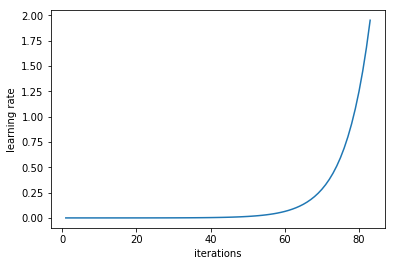

In [84]:
learner.sched.plot_lr()

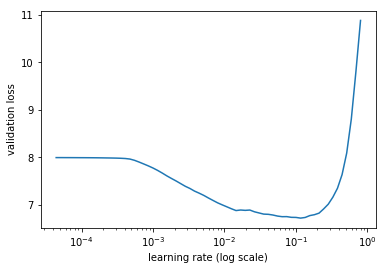

In [85]:
learner.sched.plot()

In [65]:
lr = 1e-2

In [92]:
learner.fit(lr, 3, wds=1e-6, cycle_len=1, cycle_mult=3)
#Note: if you get an error, try reducing the batch size!
#Feel free to terminate training prematurely if val_loss isn't improving

epoch      trn_loss   val_loss                                                                                         
    0      6.014169   5.951005  
    1      5.730171   5.81323                                                                                          
    2      5.537157   5.704039                                                                                         
    3      5.436423   5.682993                                                                                         
    4      5.349975   5.559585                                                                                         
    5      5.17045    5.445415                                                                                         
    6      5.025129   5.402701                                                                                         
    7      4.913526   5.375944                                                                                         
    8  

[array([5.31892])]

In [42]:
learner.save_encoder('adam1_enc')
learner.load_encoder('adam1_enc')

In [43]:
learner.fit(lr, 1, wds=1e-6, cycle_len=20)
#Feel free to terminate training prematurely if val_loss isn't improving

epoch      trn_loss   val_loss                                                                                         
    0      3.207572   5.356482  
    1      3.303996   5.373846                                                                                         
    2      3.1975     5.473306                                                                                         
    3      3.07694    5.482422                                                                                         
    4      2.93815    5.547036                                                                                         
    5      2.89259    5.41021                                                                                          
    6      2.74774    5.509189                                                                                         
    7      2.648563   5.503933                                                                                         
    8  

[array([5.51533])]

## Set your "seed string" below
(Or leave it as the default if you want it to pick a random post from your test set.)

In [93]:
#ss = random.choice(test['text'])
ss="""rat """

In [94]:
#Testing
spacy_tok = spacy.load('en')
m=learner.model
s = [spacy_tok(ss)]
t=TEXTS.numericalize(s)
' '.join(str(s[0]))
# Set batch size to 1
m[0].bs=1
# Turn off dropout
m.eval()
# Reset hidden state
m.reset()
# Get predictions from model
res,*_ = m(t)
# Put the batch size back to what it was
m[0].bs=bs

In [89]:
nexts = torch.topk(res[-1], 10)[1]
[TEXTS.vocab.itos[o] for o in to_np(nexts)]

['\n', ',', 'to', ')', 'of', 'the', 'and', '\n\n ', "n't", 'on']

In [90]:
print(ss,"\n")
for i in range(50):
    n=res[-1].topk(2)[1]
    n = n[1] if n.data[0]==0 else n[0]
    print(TEXTS.vocab.itos[n.data[0]], end=' ')
    res,*_ = m(n[0].unsqueeze(0))
print('...')

rat  


 i 'm n't the the the 
 and i 'll n't the the 
 and i 'll n't to 
 i 'll 'll n't to 
 i 'll 'll n't to 
 i 'll 'll n't to 
 i 'll 'll n't to 
 i 'll 'll n't to ...
